### Notebook for analyzing BioCentury Research Farm Accola field site - author @ Matt Nowatzke

In [1]:
import json
import pandas as pd
import geopandas as gpd
import numpy as np
import database as db
import gdal
import rasterio as rio
from rasterio.plot import plotting_extent
import analyses.run_apsim
import earthpy as et
import earthpy.plot as ep
import rasterstats as rs
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from rasterstats import zonal_stats
from analyses.munging import get_centroid
from apsim.daymet import create_excel_met
from apsim.apsim_input_writer import create_mukey_runs
from apsim.apsim_output_parser import parse_all_output_field, parse_summary_output_field
import matplotlib.pyplot as plt

### Load management data for 2018 soybeans following corn and 2019 corn following soybeans.

In [2]:
#Load the management data
accola_soy_mgmt_2018 = json.loads( open( 'crop_jsons/accola_sfc_2018.json', 'r' ).read() )
accola_corn_mgmt_2019 = json.loads( open( 'crop_jsons/accola_cfs_2019.json', 'r' ).read() )

Create database connection and get a list of all the unique soils (mukeys) for the field.

In [3]:
dbconn = db.connect_to_db('database.ini')

In [6]:
accola_soils = gpd.read_postgis('SELECT * FROM biocent_farms.accola_ssurgo;', dbconn, geom_col='wkb_geometry')
accola_mukeys = list(np.unique(accola_soils['mukey']))
#accola_soils = pd.read_sql('SELECT * FROM biocent_farms.accola_ssurgo;', dbconn)
accola_mukeys

['2765537', '2800480', '2835021', '2835194', '2922031', '411333']

### Get the centroid of the field and create met file.
This met file--if created on a Windows machine--is a an Excel file that should be saved afterwards as a Formatted Text file (*.prn)  
See: https://www.apsim.info/support/apsim-training-manuals/creating-an-apsim-met-file-using-excel/  
This is a known problem with Pandas on Windows. If creating the met file on Mac or Linux, feel free to use the daymet.create_met function instead.

In [17]:
#accola_centroid = get_centroid(accola_soils, 'areasymbol', 'wkb_geometry')
#create_excel_met(accola_centroid[0], accola_centroid[1], 2012, 2019, 'accola')

Create runs using the default soil calcs or Saxton Rawls

In [7]:
create_mukey_runs(accola_mukeys, dbconn, 'cfs', 'accola.met', 'AccolaTest', start_year=1980, end_year=2019, sfc_mgmt=accola_soy_mgmt_2018, cfs_mgmt=accola_corn_mgmt_2019)

Finished! All files created!


In [5]:
create_mukey_runs(accola_mukeys, dbconn, 'cfs', 'accola.met', 'AccolaDefault', start_year=2017, end_year=2019, sfc_mgmt=accola_soy_mgmt_2018, cfs_mgmt=accola_corn_mgmt_2019)
create_mukey_runs(accola_mukeys, dbconn, 'cfs', 'accola.met', 'AccolaSaxton', start_year=2017, end_year=2019, sfc_mgmt=accola_soy_mgmt_2018, cfs_mgmt=accola_corn_mgmt_2019, saxton=True)

Finished! All files created!
Finished! All files created!


In [6]:
create_mukey_runs(accola_mukeys, dbconn, 'sfc', 'accola.met', 'AccolaDefault', start_year=2016, end_year=2018, sfc_mgmt=accola_soy_mgmt_2018, cfs_mgmt=accola_corn_mgmt_2019)
create_mukey_runs(accola_mukeys, dbconn, 'sfc', 'accola.met', 'AccolaSaxton', start_year=2016, end_year=2018, sfc_mgmt=accola_soy_mgmt_2018, cfs_mgmt=accola_corn_mgmt_2019, saxton=True)

Finished! All files created!
Finished! All files created!


Run simulations

In [9]:
analyses.run_apsim.run_all_simulations(apsim_files_path="apsim_files\\AccolaSaxton\\2019\\cfs\\*.apsim", sim_files_path="apsim_files\\AccolaSaxton\\2019\\cfs\\*.sim")
analyses.run_apsim.run_all_simulations(apsim_files_path="apsim_files\\AccolaSaxton\\2018\\sfc\\*.apsim", sim_files_path="apsim_files\\AccolaSaxton\\2018\\sfc\\*.sim")

Running on 62 cores
Converting 6 .apsim files to .sim files.
Running Apsim for 6 .sim files...
Runs completed.
Processing time: 2.0638 seconds
Running on 62 cores
Converting 6 .apsim files to .sim files.
Running Apsim for 6 .sim files...
Runs completed.
Processing time: 2.0617 seconds


In [10]:
analyses.run_apsim.run_all_simulations(apsim_files_path="apsim_files\\AccolaDefault\\2019\\cfs\\*.apsim", sim_files_path="apsim_files\\AccolaDefault\\2019\\cfs\\*.sim")
analyses.run_apsim.run_all_simulations(apsim_files_path="apsim_files\\AccolaDefault\\2018\\sfc\\*.apsim", sim_files_path="apsim_files\\AccolaDefault\\2018\\sfc\\*.sim")

Running on 62 cores
Converting 6 .apsim files to .sim files.
Running Apsim for 6 .sim files...
Runs completed.
Processing time: 2.0612 seconds
Running on 62 cores
Converting 6 .apsim files to .sim files.
Running Apsim for 6 .sim files...
Runs completed.
Processing time: 2.0746 seconds


In [5]:
accola_soy_output_2018_saxton = parse_summary_output_field("apsim_files/AccolaSaxton/2018/sfc", year=2018)
accola_soy_output_2018_default = parse_summary_output_field("apsim_files/AccolaDefault/2018/sfc", year=2018)

In [2]:
accola_maize_output_2019_saxton = parse_summary_output_field("apsim_files/AccolaSaxton/2019/cfs", year=2019)
accola_maize_output_2019_default = parse_summary_output_field("apsim_files/AccolaDefault/2019/cfs", year=2019)

In [13]:
#accola_soy_output_2018_default.to_csv('output/apsim/accola_apsim_default_soy_2019.csv', index=False)
#accola_maize_output_2019_default.to_csv('output/apsim/accola_apsim_default_maize_2019.csv', index=False)

In [6]:
accola_apsim_yield_2018_saxton = accola_soy_output_2018_saxton[['mukey', 'soy_buac']]
accola_apsim_yield_2018_saxton

,mukey,soy_buac
0,2765537,54.05396
1,2800480,54.05395
2,2835021,54.05396
3,2835194,54.05396
4,2922031,54.05396
5,411333,54.05395


In [7]:
accola_apsim_yield_2018_default = accola_soy_output_2018_default[['mukey', 'soy_buac']]
accola_apsim_yield_2018_default

,mukey,soy_buac
0,2765537,54.05396
1,2800480,54.05394
2,2835021,54.05394
3,2835194,54.05394
4,2922031,54.05394
5,411333,54.02292


In [8]:
accola_apsim_yield_2019_saxton = accola_maize_output_2019_saxton[['mukey', 'corn_buac']]
accola_apsim_yield_2019_saxton

,mukey,corn_buac
0,2765537,190.49635
1,2800480,198.33374
2,2835021,202.98877
3,2835194,203.96081
4,2922031,200.70335
5,411333,206.77245


In [9]:
accola_apsim_yield_2019_default = accola_maize_output_2019_default[['mukey', 'corn_buac']]
accola_apsim_yield_2019_default

,mukey,corn_buac
0,2765537,201.72437
1,2800480,202.48384
2,2835021,204.03448
3,2835194,204.27408
4,2922031,203.26524
5,411333,198.65392


In [ ]:
#accola_yield = gpd.read_file("yield_monitor/Accola2019YieldwGeom.dbf")
#accola_yield_clean = accola_yield[['Yld_Vol_Dr','geometry']]
#accola_yield_clean['Yld_Vol_Dr'].describe()

In [18]:
#YM data with turn rows
#accola_ssurgo_geojson = 'C:/Users/mjn/Documents/Foresite/yield_monitor_data/analyses/accola/accola_ssurgo.geojson'
#accola_raster_yield = "C:\\Users\\mjn\\Documents\\Foresite\\yield_monitor_data\\analyses\\accola\\accola_maize_2019_raster_30.tif"

#YM data without turn rows
accola_ssurgo_geojson = "C:\\Users\\mjn\\Documents\\Foresite\\yield_monitor_data\\analyses\\accola\\ssurgo\\accola_ssurgo_noturnrows.geojson"
accola_raster_yield = "C:\\Users\\mjn\\Documents\\Foresite\\yield_monitor_data\\analyses\\accola\\yield_monitor\\no_turnrow\\accola_maize_noturn_ym_raster_2019.tif"

In [19]:
stats = zonal_stats(accola_ssurgo_geojson, accola_raster_yield, geojson_out=True, stats=['min', 'max', 'median', 'mean', 'std', 'range'])

In [20]:
accola_maize_2019 = gpd.GeoDataFrame.from_features(stats)

In [22]:
accola_maize_2019['Field'] = 'Accola'

In [23]:
accola_maize_2019 = accola_maize_2019[['geometry', 'Field', 'objectid', 'areasymbol', 'musym', 'mukey', 'shape_area', 'mean', 'median', 'min', 'max', 'std', 'range']]

In [24]:
accola_maize_2019 = accola_maize_2019.round({'mean':2,'median':2, 'min':2, 'max':2, 'std':2, 'range':2})

In [25]:
accola_maize_2019.to_file('accola_zonalstats_maize_2019.geojson', driver='GeoJSON')

In [10]:
accola_maize_2019 = gpd.read_file("accola_zonalstats_maize_2019.geojson")

In [11]:
def wkb_hexer(line):
    return line.wkb_hex

In [12]:
accola_maize_2019['geometry'] = accola_maize_2019['geometry'].apply(wkb_hexer)

In [13]:
accola_maize_df = pd.DataFrame(accola_maize_2019)

In [ ]:
db_schema = 'biocent_farms'
db_table = 'accola_maize_2019_yield_zonal_stats' 
accola_maize_df.to_sql(
con = dbconn,
name = db_table,
schema = db_schema,
if_exists = 'replace',
index = False,
chunksize=1000,
method='multi' )

In [14]:
accola_maize_2019 = accola_maize_2019[['geometry','objectid', 'mukey', 'mean']]
accola_maize_2019.sort_values('mukey')

,geometry,objectid,mukey,mean
2,01060000000100000001030000000100000045000000CF...,1673500,2765537,222.68
4,0106000000010000000103000000010000001F00000015...,1679582,2765537,209.98
5,0106000000010000000103000000010000000D0000001E...,1679975,2765537,193.95
8,0106000000020000000103000000010000000A000000C4...,1689439,2800480,177.99
15,01060000000100000001030000000100000013000000F6...,1694874,2800480,218.23
12,0106000000010000000103000000010000000F00000060...,1689902,2800480,207.48
11,010600000001000000010300000001000000080000007B...,1689892,2800480,213.58
10,0106000000010000000103000000010000000800000069...,1689765,2800480,174.42
9,0106000000010000000103000000010000000B000000EF...,1689585,2800480,201.52
17,01060000000100000001030000000100000015000000C2...,1694915,2800480,217.51


In [ ]:
with rio.open(accola_raster_yield) as src:
    accola_raster_array = src.read(1, masked=True)
accola_raster_array = accola_raster_array.ravel()

In [ ]:
plt.hist(accola_raster_array,
        color='purple')
plt.xlabel('Maize yield')
plt.ylabel('Frequency')
plt.title('Accola 2019 Maize Yield')
plt.show()

![SSURGO soils with raster yield overlay](images/accola_ssurgo_rasteryield_2019.png "Accola SSURGO soils with yield overlay")  

In [15]:
pred_vs_obs_def = accola_maize_2019.merge(accola_apsim_yield_2019_default, on='mukey', how='left')
pred_vs_obs_def.columns = ['geometry','objectid', 'mukey', 'observed', 'predicted']
pred_vs_obs_def['resid'] = pred_vs_obs_def['predicted'] - pred_vs_obs_def['observed']
pred_vs_obs_def.sort_values('mukey')

,geometry,objectid,mukey,observed,predicted,resid
2,01060000000100000001030000000100000045000000CF...,1673500,2765537,222.68,201.72437,-20.95563
4,0106000000010000000103000000010000001F00000015...,1679582,2765537,209.98,201.72437,-8.25563
5,0106000000010000000103000000010000000D0000001E...,1679975,2765537,193.95,201.72437,7.77437
8,0106000000020000000103000000010000000A000000C4...,1689439,2800480,177.99,202.48384,24.49384
15,01060000000100000001030000000100000013000000F6...,1694874,2800480,218.23,202.48384,-15.74616
12,0106000000010000000103000000010000000F00000060...,1689902,2800480,207.48,202.48384,-4.99616
11,010600000001000000010300000001000000080000007B...,1689892,2800480,213.58,202.48384,-11.09616
10,0106000000010000000103000000010000000800000069...,1689765,2800480,174.42,202.48384,28.06384
9,0106000000010000000103000000010000000B000000EF...,1689585,2800480,201.52,202.48384,0.96384
17,01060000000100000001030000000100000015000000C2...,1694915,2800480,217.51,202.48384,-15.02616


In [17]:
pred_vs_obs_def.to_csv("output/fit/accola_pvo_accola_2019.csv", index=False)

In [18]:
yield_monitor = tuple(pred_vs_obs_def['observed'])
yield_monitor = [round(num, 2) for num in yield_monitor]
apsim_predicted_def = tuple(pred_vs_obs_def['predicted'])
apsim_predicted_def = [round(num, 2) for num in apsim_predicted_def]

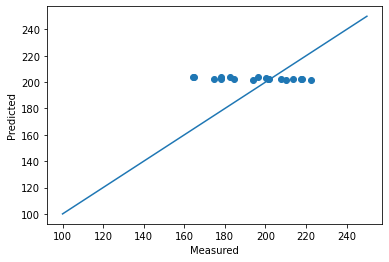

In [19]:
fig, ax = plt.subplots()
ax.scatter(yield_monitor, apsim_predicted_def)
ax.plot([100,250],[100,250])
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [20]:
rmse = mean_squared_error(yield_monitor, apsim_predicted_def, squared=False)
rmse

20.09795691661773

In [21]:
r_sq = r2_score(yield_monitor, apsim_predicted_def)
r_sq

-0.25810876449558995

In [22]:
corr_matrix = np.corrcoef(yield_monitor, apsim_predicted_def)
corr_xy = corr_matrix[0,1]
r_squared = corr_xy**2
r_squared

0.39440444805855307

In [23]:
corr_matrix

array([[ 1.        , -0.62801628],
       [-0.62801628,  1.        ]])

In [ ]:
#gdal.Grid('yield_avg.tif', 'accola_yield_basic.csv')

In [ ]:
def reproject(vector_gpd, raster):
    proj = raster.crs.to_epsg()
    print("Original vector layer projection: ", vector_gpd.crs)
    reproj = vector_gpd.to_crs(proj)
    print("New vector layer projection (PROJ4): ", reproj.crs)
    return reproj

In [ ]:
yield_with_dem_path = "C:\\Users\\mjn\\Documents\\Foresite\\yield_monitor_data\\analyses\\accola\\accola_maize_2019_yield_w_elev_noturnrows.geojson"

In [ ]:
yld_with_dem = gpd.read_file(yield_with_dem_path)

In [ ]:
yld_with_dem.head()

In [ ]:
yld_with_dem = yld_with_dem.round({'Yld_Vol_Dr':2})
yld_with_dem = yld_with_dem.astype({'Obj__Id':'int32'})

In [ ]:
yld_with_dem.head()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(yld_with_dem['Yld_Vol_Dr'], yld_with_dem['rvalue_1'], alpha=0.2)
ax.set_xlabel('Yield Monitor (bu/ac')
ax.set_ylabel('DEM (elevation)')
plt.show()

In [ ]:
len(yld_with_dem['Yld_Vol_Dr'])

In [ ]:
dem_pred = tuple(yld_with_dem['rvalue_1'])
yld_obsv = tuple(yld_with_dem['Yld_Vol_Dr'])

In [ ]:
corr_matrix = np.corrcoef(yld_obsv, dem_pred)
corr_xy = corr_matrix[0,1]
corr_xy

In [ ]:
yield_with_ym_elev_path = "C:\\Users\\mjn\\Documents\\Foresite\\yield_monitor_data\\analyses\\accola\\accola_maize_2019_noturn_ym_elev.geojson"
yield_with_ym_elev_path = gpd.read_file(yield_with_ym_elev_path)

In [ ]:
yield_with_ym_elev_path.head()

In [ ]:
yield_with_ym_elev_path = yield_with_ym_elev_path.round({'Yld_Vol_Dr':2})
yield_with_ym_elev_path = yield_with_ym_elev_path.astype({'Obj__Id':'int32'})

In [ ]:
yield_with_ym_elev_path.head()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(yield_with_ym_elev_path['Yld_Vol_Dr'], yield_with_ym_elev_path['Elevation_'], alpha=0.2)
ax.set_xlabel('Yield Monitor (bu/ac')
ax.set_ylabel('Yield Monitor Elevation')
plt.show()

In [ ]:
ym_elev = tuple(yield_with_ym_elev_path['Elevation_'])
yld_obsv = tuple(yield_with_ym_elev_path['Yld_Vol_Dr'])

In [ ]:
corr_matrix = np.corrcoef(yld_obsv, ym_elev)
corr_xy = corr_matrix[0,1]
corr_xy